In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

### Download the dataset from fastai 

In [4]:
path = untar_data(URLs.PETS); path

PosixPath('/home/kelwa/.fastai/data/oxford-iiit-pet')

In [5]:
path.ls()

[PosixPath('/home/kelwa/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/kelwa/.fastai/data/oxford-iiit-pet/annotations')]

In [6]:
anno_path = path/'annotations'
images_path = path/'images'

### Create a Databunch using Data Block API

In [7]:
fnames = get_image_files(images_path)
fnames[:5]

[PosixPath('/home/kelwa/.fastai/data/oxford-iiit-pet/images/Russian_Blue_202.jpg'),
 PosixPath('/home/kelwa/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_150.jpg'),
 PosixPath('/home/kelwa/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_144.jpg'),
 PosixPath('/home/kelwa/.fastai/data/oxford-iiit-pet/images/chihuahua_145.jpg'),
 PosixPath('/home/kelwa/.fastai/data/oxford-iiit-pet/images/Ragdoll_185.jpg')]

In [8]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [9]:
src = (ImageList.from_folder(images_path)
      .split_by_rand_pct(0.2)
      .label_from_re(pat))

In [10]:
data = (src.transform(tfms=get_transforms(), size=128)
       .databunch().normalize(imagenet_stats))

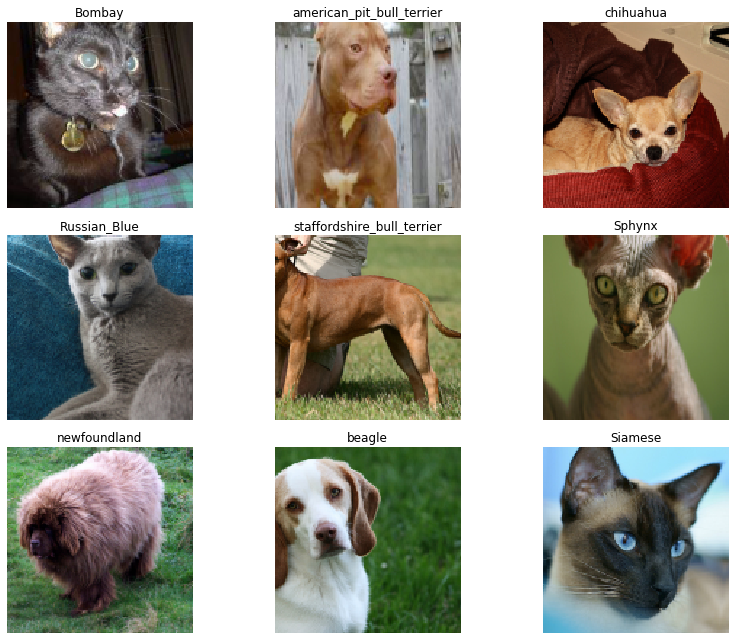

In [11]:
data.show_batch(rows=3, figsize=(12,9))

In [12]:
print(data.classes)
len(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


37

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [21]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.107022,0.750368,0.220568,00:33
1,1.116187,0.562137,0.181326,00:31
2,0.767479,0.463098,0.149526,00:31
3,0.607520,0.429525,0.137348,00:30


In [22]:
learn.save('124-resnet32-1')

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idx = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idx) # sanity check

True

### Top inaccurate predictions

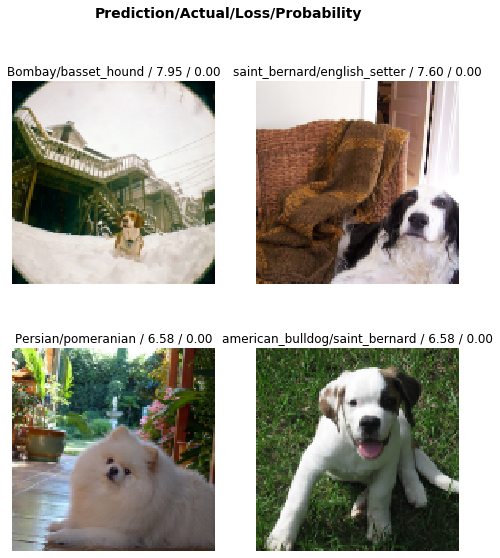

In [26]:
# plot top losses
interp.plot_top_losses(4, figsize=(8, 9))

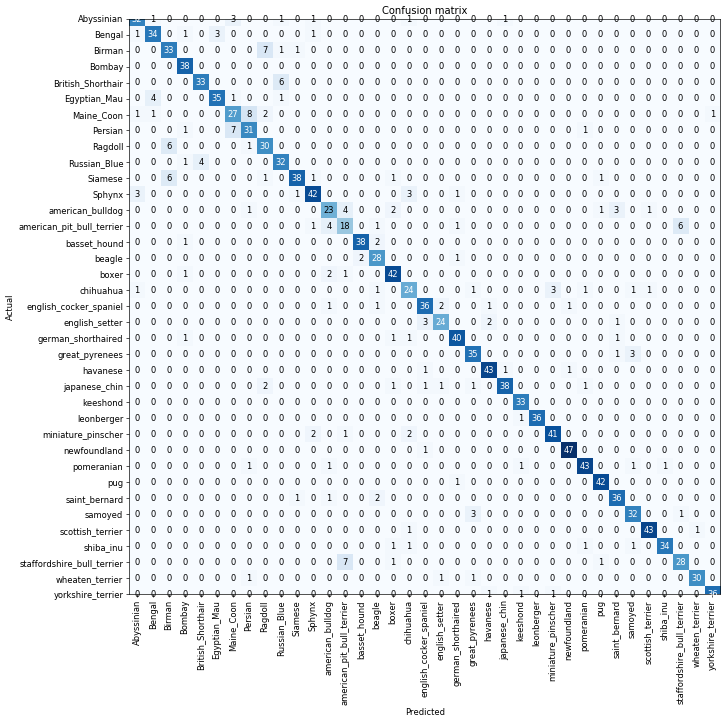

In [27]:
interp.plot_confusion_matrix(figsize=(12,13), dpi=60)

In [28]:
interp.most_confused(min_val=3)

[('Maine_Coon', 'Persian', 8),
 ('Birman', 'Ragdoll', 7),
 ('Persian', 'Maine_Coon', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('British_Shorthair', 'Russian_Blue', 6),
 ('Ragdoll', 'Birman', 6),
 ('Siamese', 'Birman', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('american_bulldog', 'american_pit_bull_terrier', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('Abyssinian', 'Maine_Coon', 3),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Sphynx', 'Abyssinian', 3),
 ('Sphynx', 'chihuahua', 3),
 ('american_bulldog', 'saint_bernard', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('english_setter', 'english_cocker_spaniel', 3),
 ('great_pyrenees', 'samoyed', 3),
 ('samoyed', 'great_pyrenees', 3)]

### Resnet50
* restart the kernel to avoid memory limit

In [13]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.410424,0.676059,0.200271,00:34
1,0.840218,0.481479,0.171854,00:31
2,0.578858,0.389075,0.127876,00:32
3,0.406658,0.380233,0.123139,00:31


In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


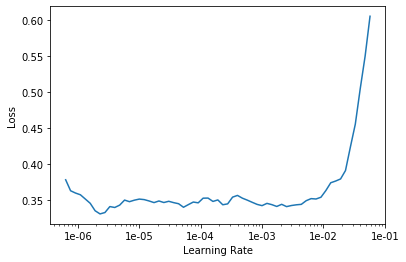

In [17]:
learn.recorder.plot()

In [18]:
lr = 1e-3

In [19]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.358803,0.374495,0.117727,00:31
1,0.402915,0.380236,0.111637,00:32
2,0.371650,0.369076,0.120433,00:33
3,0.316932,0.343383,0.113667,00:33
4,0.262827,0.341279,0.108931,00:33


In [20]:
learn.save('stage-1-128-rn50')

#### Fine tune 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


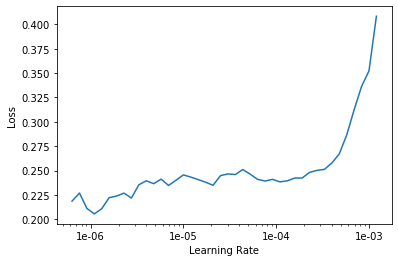

In [21]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(5, slice(1e-5, lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.283781,0.421654,0.125169,00:38
1,0.395530,0.469838,0.148850,00:38
2,0.301545,0.354262,0.114344,00:38
3,0.193117,0.330597,0.104871,00:39
4,0.125379,0.316030,0.101489,00:39


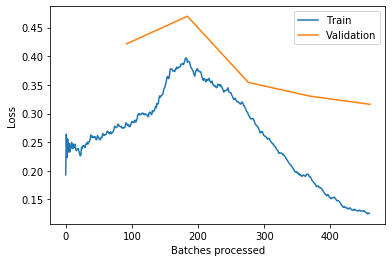

In [26]:
learn.recorder.plot_losses()

In [27]:
# incase of not so good lr
learn.load('stage-1-128-rn50');

In [30]:
learn.fit_one_cycle(5, slice(1e-4/2, lr/2))

epoch,train_loss,valid_loss,error_rate,time
0,0.334517,0.480617,0.145467,00:38
1,0.529567,0.606265,0.171177,00:38
2,0.387450,0.378243,0.120433,00:38
3,0.210113,0.333247,0.103518,00:38
4,0.139002,0.316061,0.094723,00:39


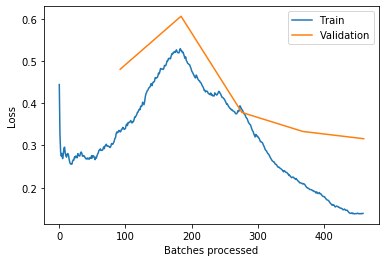

In [31]:
learn.recorder.plot_losses()

In [32]:
learn.save('stage-2-128-rn50')

### More fine tunning, full size images 

In [11]:
# Another kernel restart "Cuda out of memory!!"
# create learner based on old data
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
# load weights
learn.load('stage-2-128-rn50');

# get the new data :) 
data = (src.transform(tfms=get_transforms(), size=224)
       .databunch(bs=32).normalize(imagenet_stats))

# replace the old data but with the same learner
learn.data = data
# check
data.train_ds[0][0].shape

torch.Size([3, 224, 224])

In [12]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


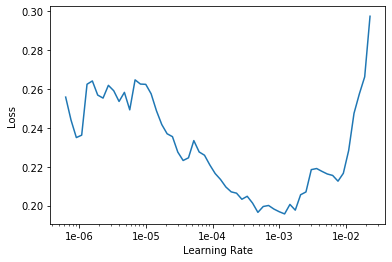

In [13]:
learn.lr_find() # if it's good at 128 it will be at least ok with 224
learn.recorder.plot()

In [21]:
lr = 1e-3/2

In [22]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.209485,0.228166,0.066306,01:16
1,0.200886,0.212170,0.066982,01:15
2,0.147676,0.206059,0.063599,01:16
3,0.126755,0.205291,0.063599,01:16
4,0.103710,0.203018,0.060893,01:19


In [28]:
learn.save('stage-1-224-rn50')

In [29]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


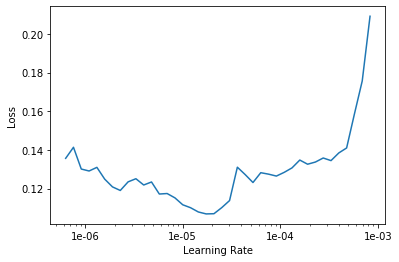

In [25]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(5, slice(1e-5/2, 2e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.032138,0.185347,0.058863,01:44
1,0.032616,0.187600,0.058187,01:49
2,0.029334,0.180249,0.054804,01:48
3,0.021970,0.182025,0.054804,01:46
4,0.015801,0.174859,0.056157,01:50


In [35]:
learn.save('stage-2-224-rn50')

In [36]:
learn.fit_one_cycle(5, slice(1e-5/2, 2e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.016755,0.182412,0.053451,01:44
1,0.024631,0.178775,0.055480,01:46
2,0.018776,0.179656,0.057510,01:51
3,0.012004,0.185304,0.056834,01:53
4,0.019741,0.177224,0.051421,01:53


In [37]:
learn.save('stage-3-224-rn50')

In [40]:
learn.load('stage-3-224-rn50');

In [44]:
learn.export(path/'pets.pkl')

In [45]:
# classes for web app
data.classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']